# **Transformer**
Transformers are the building blocks of modern LLMs, enabling the prediction of words in context. Traditional language models, such as N-Grams, predict words based on frequency (for example, if a word often appears with another, it will be generated even if it makes no sense). In contrast, the Transformer model, specifically through the Attention mechanism, addresses the fact that some words are more important than others. This allows the model to better capture context and meaning.

For the following demonstration, we will use the WikiText-103 dataset. You can find it here: [[Dataset]](https://https://www.kaggle.com/datasets/vadimkurochkin/wikitext-103?resource=download)

In [1]:
import kagglehub

path = kagglehub.dataset_download("vadimkurochkin/wikitext-103")

print("Path to dataset files:", path)

100%|██████████| 184M/184M [00:01<00:00, 159MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vadimkurochkin/wikitext-103/versions/1


**Transformer Architecture**


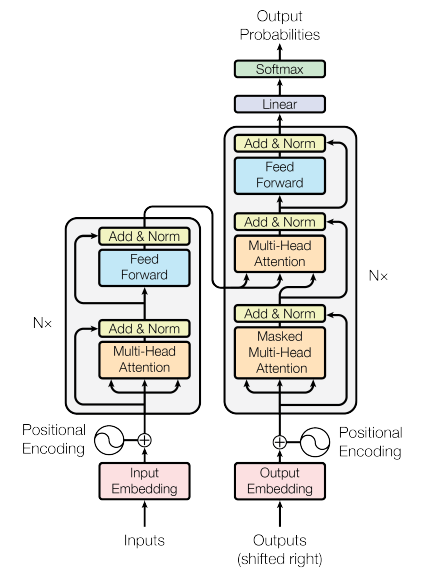

Understanding the architecture of a transformer is key in making it, based on the picture above there are several key components towards making it. such as the positional encoding mechanism, attention mechanism, neural network, and layer norm.

In [2]:
import numpy as np
import io
import re
from collections import Counter

# **Tokenizer**

In [41]:
with io.open("sample_data/wikitext-103/wiki.train.tokens", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Sample:", raw_text[:500])

Sample:  
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs par


In [42]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"=+.*=+", " ", text)
    text = re.sub(r"[^a-z0-9.,!?;:'\"()\-\n ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_text = clean_text(raw_text)
print(cleaned_text[:500])

senj no valkyria 3 : unk chronicles ( japanese : 3 , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a tactical role - playing video game developed by sega and media.vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . employing the same fusion of tactical and real - time gameplay as its predecessors , the story runs parallel to the first game and follows the " nameless "


After cleaning the text, we can tokenize it. **Tokenization** is the process of breaking down text into smaller units called tokens. In this case, the `simple_tokenize` function is used to split the text into a list of words based on whitespace.

In [5]:
def simple_tokenize(text):
    return text.split()

tokens = simple_tokenize(cleaned_text)
print("Number of tokens:", len(tokens))
print("First 20 tokens:", tokens[:20])

Number of tokens: 575094
First 20 tokens: ['senj', 'no', 'valkyria', '3', ':', 'unk', 'chronicles', '(', 'japanese', ':', '3', ',', 'lit', '.', 'valkyria', 'of', 'the', 'battlefield', '3', ')']


After tokenizing the data, we can convert words into integer IDs. For example, special tokens such as PAD (padding), UNK (unknown), START, and END are assigned reserved IDs at the beginning of the vocabulary. The remaining top 50,000 most frequent words are each assigned a unique integer ID, with smaller numbers representing higher frequency (e.g., ID 4 might correspond to the most frequent word). Any words that fall outside of the top 50,000 are mapped to the UNK token.

In [6]:
PAD, UNK, START, END = 0, 1, 2, 3

counter = Counter(tokens)
max_vocab = 50000
most_common = counter.most_common(max_vocab - 4)

vocab = {"<pad>":PAD, "<unk>":UNK, "<s>":START, "</s>":END}
for i, (word, _) in enumerate(most_common, start=4):
    vocab[word] = i

inv_vocab = {i: w for w, i in vocab.items()}

print("Vocab size:", len(vocab))
print("Sample vocab:", list(vocab.items())[:20])

Vocab size: 30659
Sample vocab: [('<pad>', 0), ('<unk>', 1), ('<s>', 2), ('</s>', 3), ('the', 4), (',', 5), ('.', 6), ('of', 7), ('and', 8), ('in', 9), ('to', 10), ('a', 11), ('"', 12), ('was', 13), ('-', 14), ('as', 15), ('on', 16), ('that', 17), ('for', 18), ('with', 19)]


After making the id encoder for the data we can actually encode based on the input available

In [43]:
def encode(tokens, vocab):
    # If a single sentence (list of strings)
    if isinstance(tokens[0], str):
        return [vocab.get(t, vocab["<unk>"]) for t in tokens]
    # If a batch of sentences (list of list)
    elif isinstance(tokens[0], list):
        return [[vocab.get(t, vocab["<unk>"]) for t in sentence] for sentence in tokens]
    else:
        raise ValueError("Input must be a list of strings or a list of list of strings")

encoded_tokens = encode(tokens, vocab)
print("Encoded sample:", encoded_tokens[:50])


Encoded sample: [8295, 113, 1220, 97, 48, 25, 1546, 23, 1193, 48, 97, 5, 4304, 6, 1220, 7, 4, 4576, 97, 24, 5, 1840, 1469, 10, 15, 1220, 1546, 896, 556, 928, 5, 22, 11, 4083, 281, 14, 543, 291, 120, 485, 21, 6697, 8, 11223, 18, 4, 4899, 9497, 6, 167]


# **Word Embedding**

After encoding the tokens, the next step is word embedding. Word embeddings transform the integer IDs (derived from tokens) into dense vectors. Each vector represents a word in a continuous space where different dimensions can capture semantic or syntactic attributes. For example, certain dimensions may correspond to features like sentiment, tone, or relationships between words. This allows the model to understand words beyond their discrete IDs and capture richer context. Fortunately, we don't have to train our embedding matrix, but if we do it'll be a lot harder to figure it out on how it works.

In [8]:
vocab_size = len(vocab)
d_model = 128
rng = np.random.default_rng(42)

embedding_matrix = rng.normal(0, 0.02, size=(vocab_size, d_model))

Now, we'll make an example

In [9]:
sentence_ids = np.array([2, 4, 5, 6, 7, 3, 0, 0])

embedded = embedding_matrix[sentence_ids]
print(embedded.shape)

(8, 128)


In [10]:
print(embedded)

[[ 0.00869532 -0.00752312 -0.00267646 ...  0.02619101 -0.03204519
  -0.02503294]
 [ 0.00198955 -0.00172201  0.01581612 ... -0.02226776  0.01159122
   0.01049015]
 [-0.02988811  0.01398393  0.0410537  ... -0.03567222  0.00167242
  -0.01112384]
 ...
 [-0.03202556 -0.01588273  0.00879273 ...  0.0093016  -0.03121917
  -0.00594647]
 [ 0.00609434 -0.02079968  0.01500902 ...  0.00713742  0.02926606
  -0.02377526]
 [ 0.00609434 -0.02079968  0.01500902 ...  0.00713742  0.02926606
  -0.02377526]]


In [11]:
batch_ids = np.array([
    [2, 4, 5, 6, 7, 3, 0, 0, 12],
])

batch_embedded = embedding_matrix[batch_ids]
print(batch_embedded.shape)  # (1, 8, 128)

(1, 9, 128)


# **Positional Encoding**

Now, after word embedding we still need to encode the position of the words, with embedding only it doesn't learn the position of the words, let's make an example


```
Man bites Dog ≠ Dog bites man
```

Position matters in language models like this, often AI models encode their position by 2 ways (Sinuosidal, or Learned). For this project we are going to use sinuosidal since it offers generalization for longer sequences, now for learned it doesn't offer us generalization since it's usually limited by the maximum number of token that is used to train.

For the formula itself we could take a look below

$$
PE_{(pos, 2i)} = \sin\!\left(\frac{pos}{10000^{\tfrac{2i}{d_{\text{model}}}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\!\left(\frac{pos}{10000^{\tfrac{2i}{d_{\text{model}}}}}\right)
$$



*   $PE$ = Positional Encoding
*   $i$ = index
*   $d_{model}$ = dimensionality (128,256,512)





In [13]:
class PositionalEncoding:
    def __init__(self, max_len: int, d_model: int):
        self.d_model = d_model
        self.max_len = max_len
        self.pe = self._create_positional_encoding(max_len, d_model)

    def _create_positional_encoding(self, max_len, d_model):
        pos = np.arange(max_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
        angles = pos * angle_rates

        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(angles[:, 0::2])
        pe[:, 1::2] = np.cos(angles[:, 1::2])
        return pe

    def __call__(self, x):
        seq_len = x.shape[1]
        # Auto-expand if sequence is longer than precomputed PE
        if seq_len > self.max_len:
            self.pe = self._create_positional_encoding(seq_len, self.d_model)
            self.max_len = seq_len
        return x + self.pe[:seq_len]


positional_encode = PositionalEncoding(max_len=8, d_model=128)
positioned_word = positional_encode(batch_embedded)

In [14]:
print(positioned_word)
print(positioned_word.shape)

[[[ 0.00869532  0.99247688 -0.00267646 ...  1.02619101 -0.03204519
    0.97496706]
  [ 0.84346053  0.53858029  0.77753653 ...  0.97773223  0.0117067
    1.01049014]
  [ 0.87940931 -0.4021629   1.02809995 ...  0.96432774  0.00190338
    0.98887613]
  ...
  [-0.27332116  0.9393706  -0.87041214 ...  1.0071371   0.02995893
    0.9762245 ]
  [ 0.66308094  0.73310257 -0.20462083 ...  1.00713699  0.03007441
    0.97622441]
  [ 1.00434271 -0.17924699  0.58221693 ...  0.97799672 -0.00112942
    1.03596533]]]
(1, 9, 128)


# **Self Attention**

Self attention is a mechanic in LLM, to identify the context itself and who and how does this word relate towards each other. By its name we can conclude self attention means how much attention we give towards other tokens. Let's take a look at an example



```
The dog ate a lot of junk food, it became sick afterwads.
```

With self attention, we can see that "it" actually refers to the dog that ate a lot of junk food. Without this mechanism, it's hard to understand context and how important some word is, compared to another.

Generally, when making self attention each token gets divided into 3 vectors

$$
Q=XW^{Q}, K = XW^{K}, V=XW^{V}
$$
Where,

$Q$ = Query

$K$ = Key

$V$ = Value

Now each of this vectors mean different things, Query means what are we looking for, Key what it contains, Value what information it holds.


In [15]:
def softmax(x, axis=-1):
  x = x - np.max(x, axis=axis, keepdims=True)
  return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def self_attention(X, d_models=128, d_k=16, seed=42):
  rng = np.random.default_rng(seed)

  W_Q = rng.normal(0, 0.02, (d_models, d_k))
  W_K = rng.normal(0, 0.02, (d_models, d_k))
  W_V = rng.normal(0, 0.02, (d_models, d_k))

  Q = X @ W_Q
  K = X @ W_K
  V = X @ W_V

  scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
  attention_weights = softmax(scores)
  output = attention_weights @ V
  return output, attention_weights


In [16]:
out, attn = self_attention(positioned_word, d_models=128, d_k=8)

print("Output shape:", out.shape)
print("Attention matrix:\n", attn)

Output shape: (1, 9, 8)
Attention matrix:
 [[[0.11044727 0.1102536  0.11035619 0.11067361 0.11101604 0.11134525
   0.11176466 0.11203992 0.11210346]
  [0.11022922 0.10985882 0.11006956 0.11068152 0.1112764  0.11166625
   0.11196442 0.11211003 0.11214378]
  [0.11013309 0.10976185 0.11002187 0.11074722 0.11141234 0.11184364
   0.11204183 0.11205836 0.11197982]
  [0.11010422 0.10991497 0.11019592 0.11083077 0.11139352 0.11183034
   0.11199856 0.11196677 0.11176493]
  [0.1103419  0.11040102 0.11062202 0.11100068 0.11128525 0.11161979
   0.11175011 0.11166159 0.11131765]
  [0.11054614 0.11078718 0.11099733 0.11120951 0.11128469 0.11147927
   0.11152557 0.11132736 0.11084294]
  [0.11067142 0.11090941 0.11113406 0.11137004 0.11141177 0.11150096
   0.11142871 0.11107899 0.11049464]
  [0.11063485 0.11078141 0.11103989 0.1114096  0.11156331 0.11165481
   0.11150567 0.11103419 0.11037627]
  [0.11052687 0.11057896 0.11083433 0.11131523 0.11160756 0.11180113
   0.11166911 0.11117471 0.11049209]]]


# **Causal Mask**

When we're making a decoder we need to make sure that each token can't see the future, this is sometimes called data leakage. Let's take a look at an example

Suppose we have a sentence with 3 words such as



```
I ate breakfast
```

When the text is tokenized and passed into the attention mechanism, it forms a matrix where each element $t_{ij}$ represents the attention score between token $i$ and token $j$. In this matrix if $i$ > $j$, it means the model is attending to future tokens—essentially “peeking” at the next words, which is something we usually prevent in causal (autoregressive) models.

$$
\begin{bmatrix}
t_{11} & t_{12} & t_{13}  \\
t_{21} & t_{22} & t_{23} \\
t_{31} & t_{32} & t_{33}
\end{bmatrix}
$$

Now one way to prevent this is by blocking the attention for token in which $i$ > $j$, such that the current token cannot see the future attention score like below

$$
\begin{bmatrix}
t_{11} & -\infty & -\infty \\
t_{21} & t_{22} & -\infty \\
t_{31} & t_{32} & t_{33}
\end{bmatrix}
$$

In [25]:
def make_causal_mask(T):
    mask = np.triu(np.ones((T, T)), k=1) * -1e9
    return mask[None, None, :, :]

# **Multi Head Attention**



Now that we’ve implemented self-attention, the next step is multi-head attention. With self-attention, we can capture the relationships between words in a sequence (for example, identifying that one word is the subject of another). Multi-head attention extends this idea by using several attention heads in parallel. Each head can focus on different aspects of the context. For instance, one head might learn to track which word is the subject, while another could capture emotional connotations, and yet another could handle positional or syntactic relationships.

In [17]:
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)  # stability
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):

    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)  # (B,H,T,T)
    if mask is not None:
        scores = scores + mask  # mask should be 0 for keep, -1e9 for mask
    attn = softmax(scores, axis=-1)
    out = np.matmul(attn, V)  # (B,H,T,Dh)
    return out, attn

def make_causal_mask(T):
    mask = np.triu(np.ones((T, T)), k=1) * -1e9
    mask = mask[None, None, :, :]  # (1,1,T,T)
    return mask



In [18]:
class MultiHeadAttention:
    def __init__(self, d_model=128, num_heads=8, seed=42):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        rng = np.random.default_rng(seed)

        # Projection matrices (learnable params)
        self.W_Q = rng.normal(0, 0.02, (d_model, d_model)).astype(np.float32)
        self.W_K = rng.normal(0, 0.02, (d_model, d_model)).astype(np.float32)
        self.W_V = rng.normal(0, 0.02, (d_model, d_model)).astype(np.float32)
        self.W_O = rng.normal(0, 0.02, (d_model, d_model)).astype(np.float32)

    def _split_heads(self, x, B, T):
        return x.reshape(B, T, self.num_heads, self.d_head).transpose(0, 2, 1, 3)

    def _combine_heads(self, x, B, T):
        return x.transpose(0, 2, 1, 3).reshape(B, T, self.d_model)

    def __call__(self, X, mask=None):
        B, T, D = X.shape

        # Linear projections
        Q = X @ self.W_Q
        K = X @ self.W_K
        V = X @ self.W_V

        # Split into heads
        Qh = self._split_heads(Q, B, T)  # (B,H,T,Dh)
        Kh = self._split_heads(K, B, T)
        Vh = self._split_heads(V, B, T)

        # Scaled dot-product attention
        out_h, attn = scaled_dot_product_attention(Qh, Kh, Vh, mask)

        # Combine heads + final linear projection
        out = self._combine_heads(out_h, B, T)  # (B,T,D)
        out = out @ self.W_O                   # (B,T,D)

        return out, attn


In [19]:
mha = MultiHeadAttention(d_model=128, num_heads=8)
out_multihead, attention = mha(positioned_word, mask)
print(out_multihead.shape)
print(attention.shape)

(1, 9, 128)
(1, 8, 9, 9)


# **Feed Forward Network**

In a language model, attention alone isn’t enough—we also need a neural network. Attention helps the model understand the context and relationships between words. However, the neural network extends this by allowing the model to generalize and derive higher-level meaning from that context.

Consider the example:



```
That person just won a video game tournament, so he has a lot of money.
```

Through attention, the model understands that “he” refers to “that person.” But this is only a surface-level understanding. The neural network builds on this by learning deeper connections—such as associating “won a tournament” with “a lot of money.”

In essence, attention captures relationships, while the neural network generalizes those relationships to form a richer understanding of the entire sentence.

In [20]:
class PositionwiseFeedForward:
    def __init__(self, d_model=128, d_ff=512, seed=42, activation="relu"):
        rng = np.random.default_rng(seed)

        self.W1 = rng.normal(0, 0.02, (d_model, d_ff)).astype(np.float32)
        self.b1 = np.zeros((d_ff,), dtype=np.float32)

        self.W2 = rng.normal(0, 0.02, (d_ff, d_model)).astype(np.float32)
        self.b2 = np.zeros((d_model,), dtype=np.float32)
        self.activation = activation

    def __call__(self, X):

        hidden = X @ self.W1 + self.b1
        if self.activation == "relu":
            hidden = np.maximum(0, hidden)

        out = hidden @ self.W2 + self.b2
        return out


In [21]:
ffn = PositionwiseFeedForward(d_model=128, d_ff=512)
out_ffn = ffn(out_multihead)

print("Input shape:", out_multihead.shape)   # (2, 8, 128)
print("Output shape:", out_ffn.shape) # (2, 8, 128)

Input shape: (1, 9, 128)
Output shape: (1, 9, 128)


# **Layer Norm**

Another important component of a language model is Layer Normalization. In traditional neural networks, we know that deeper architectures can suffer from issues where values either explode or vanish as they propagate through layers.

In the context of language models, this means that without LayerNorm, the model’s representation of knowledge can become unstable. It might:
A. Become too dominant toward a specific pattern or concept, ignoring other relevant information, or
B. Become too weak, causing certain learned knowledge to be effectively forgotten as its value approaches zero.

In simple terms, LayerNorm acts like a self-check mechanism for the model, a way of asking

*“Are you doing too much?”*

It keeps the model balanced, preventing any single piece of information from overwhelming or disappearing within the network.

In [22]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones((d_model,), dtype=np.float32)
        self.beta = np.zeros((d_model,), dtype=np.float32)
        self.eps = eps

    def __call__(self, X):
        mean = np.mean(X, axis=-1, keepdims=True)
        var = np.var(X, axis=-1, keepdims=True)
        normed = (X - mean) / np.sqrt(var + self.eps)
        return self.gamma * normed + self.beta


In [23]:
class ResidualConnection:
    def __init__(self, d_model):
        self.norm = LayerNorm(d_model)

    def __call__(self, X, sublayer_out):
        return self.norm(X + sublayer_out)

In [24]:
residual = ResidualConnection(d_model=128)
out_residual = residual(out_multihead, out_ffn)

print("Input shape:", out_multihead.shape)
print("Residual+Norm output shape:", out.shape)

Input shape: (1, 9, 128)
Residual+Norm output shape: (1, 9, 8)


# **Decoder Block**

When building a Transformer, we combine several components into what’s called a decoder block. This block brings together all the elements we’ve discussed self-attention, feed-forward layers, and layer normalization. These components are arranged and stacked in the following architecture:


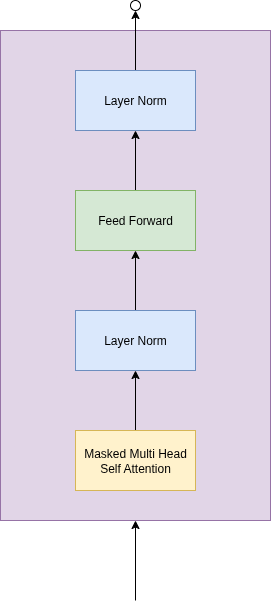

In [26]:
class DecoderBlock:
    def __init__(self, d_model=128, num_heads=8, d_ff=512, seed=42, cross_attention=false):

        self.self_attn = MultiHeadAttention(d_model, num_heads, seed)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, seed + 1) if cross_attention else None
        self.ffn = PositionwiseFeedForward(d_model, d_ff, seed + 2)

        self.res1 = ResidualConnection(d_model)
        self.res2 = ResidualConnection(d_model) if cross_attention else None
        self.res3 = ResidualConnection(d_model)

    def __call__(self, x, enc_output=None, self_mask=None, enc_dec_mask=None):

        self_attn_out, _ = self.self_attn(x, mask=self_mask)
        x = self.res1(x, self_attn_out)

        if self.cross_attn is not None and enc_output is not None:
            Q = x
            K = enc_output
            V = enc_output

            B, T, D = Q.shape
            _, S, _ = K.shape

            Q_proj = Q @ self.cross_attn.W_Q
            K_proj = K @ self.cross_attn.W_K
            V_proj = V @ self.cross_attn.W_V

            Qh = self.cross_attn._split_heads(Q_proj, B, T)
            Kh = self.cross_attn._split_heads(K_proj, B, S)
            Vh = self.cross_attn._split_heads(V_proj, B, S)

            cross_out, _ = scaled_dot_product_attention(Qh, Kh, Vh, mask=enc_dec_mask)

            cross_out = self.cross_attn._combine_heads(cross_out, B, T)
            cross_out = cross_out @ self.cross_attn.W_O

            x = self.res2(x, cross_out)

        ffn_out = self.ffn(x)
        x = self.res3(x, ffn_out)

        return x


# **Transformer Model**

Now that we have built and understood each component, we can see how they work together to form the full Transformer architecture. The complete model can be represented as shown in the picture below, where several decoder blocks are stacked one after another.

This structure shows how data flows through the model, starting from token inputs, passing through multiple layers of self-attention, feed-forward networks, and layer normalization, before finally reaching the output layer. Each decoder block refines the representation further, allowing the model to capture deeper context and more complex relationships between words.

Together, these stacked decoder blocks form the foundation of the Transformer, enabling it to understand context, reason about meaning, and generate coherent sentences.

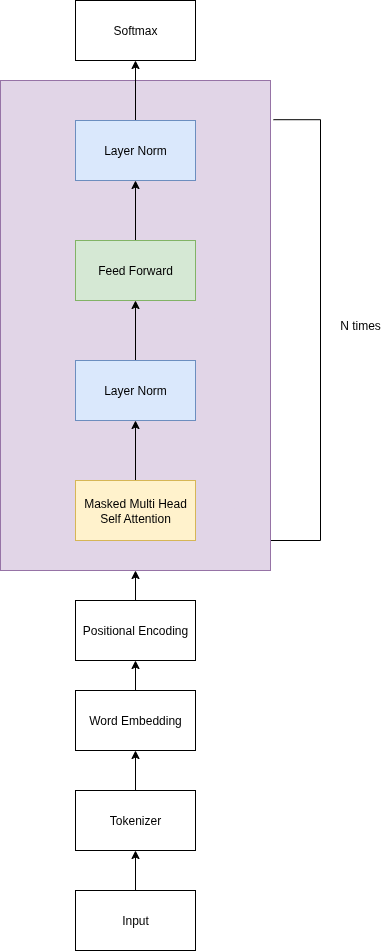

In [44]:
class TransformerDecoder:
    def __init__(self, vocab_size, d_model=128, num_heads=8, d_ff=512, num_layers=2, max_len=100, seed=42):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.pos_encoding = PositionalEncoding(max_len=max_len, d_model=d_model)
        self.layers = [DecoderBlock(d_model, num_heads, d_ff, seed + i) for i in range(num_layers)]

        rng = np.random.default_rng(seed)
        self.W_out = rng.normal(0, 0.02, (d_model, vocab_size)).astype(np.float32)
        self.b_out = np.zeros((vocab_size,), dtype=np.float32)

    def __call__(self, x, self_mask=None):
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x, self_mask=self_mask)

        logits = x @ self.W_out + self.b_out  # (B, T, vocab_size)

        last_token_logits = logits[:, -1, :]  # (B, vocab_size)
        probs = np.exp(last_token_logits - np.max(last_token_logits, axis=-1, keepdims=True))
        probs = probs / np.sum(probs, axis=-1, keepdims=True)

        return logits, probs


In [51]:
input_tokens = [['the', 'art', 'of', 'war']]
encoded_tokens = encode(input_tokens, vocab)

rng = np.random.default_rng(42)
embedded = embedding_matrix[encoded_tokens]

print(embedded.shape)

(1, 4, 128)


In [53]:
B, T, D = embedded.shape

decoder = TransformerDecoder(vocab_size=vocab_size, d_model=D, num_heads=8, num_layers=5)

mask = make_causal_mask(T)

logits, probs = decoder(embedded, self_mask=mask)

In [54]:
print("Logits shape:", logits.shape)  # (B, T, vocab_size)
print("Next token prob shape:", probs.shape)  # (B, vocab_size)

Logits shape: (1, 4, 30659)
Next token prob shape: (1, 30659)


In [55]:
print(logits)
print(probs)

[[[ 0.16508727  0.0175659   0.15031728 ...  0.02090813  0.04915541
   -0.17508453]
  [ 0.23154073  0.03160694  0.07573692 ... -0.02613881  0.04917516
   -0.3080022 ]
  [ 0.14832552  0.13016722  0.0733087  ... -0.08301666  0.02936145
   -0.51078994]
  [ 0.05352065  0.23057581  0.13742616 ... -0.15670264  0.00602828
   -0.51852867]]]
[[3.35789542e-05 4.00830947e-05 3.65179903e-05 ... 2.72124943e-05
  3.20214869e-05 1.89508766e-05]]
